In [ ]:

import pandas as pd                                                             #Import Libraries
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:

drive.mount('/content/drive')


train_file_path = '/content/drive/My Drive/bank+marketing/bank-additional/bank-additional-full.csv' # Load Data
                                                                                                    # Paths for datasets
test_file_path = '/content/drive/My Drive/bank+marketing/bank-additional/bank-additional.csv'


train_data = pd.read_csv(train_file_path, sep=';').    # Load datasets
test_data = pd.read_csv(test_file_path, sep=';')

print("Training Dataset Shape:", train_data.shape)
print("Validation/Test Dataset Shape:", test_data.shape)

Mounted at /content/drive
Training Dataset Shape: (41188, 21)
Validation/Test Dataset Shape: (4119, 21)


In [ ]:
print("First 5 Rows: train")          # print First 5 Rows
print(train_data.head())

print("First 5 Rows: test")
print(test_data.head())

First 5 Rows: train
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  eu

In [ ]:
# Data Preprocessing

def preprocess_data(df):

    df['y'] = df['y'].map({'yes': 1, 'no': 0})                          # Map target variable to binary


    for col in df.columns:                                              # Handle 'unknown' values (replace with mode for categorical, median for numerical)
        if df[col].dtype == 'object':
            df[col] = df[col].replace('unknown', df[col].mode()[0])
        elif pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].replace('unknown', df[col].median())


    binary_features = ['default', 'housing', 'loan']                    # Encode binary features
    for col in binary_features:
        df[col] = df[col].map({'yes': 1, 'no': 0})


    df['pdays_cat'] = df['pdays'].apply(lambda x: 1 if x > 0 else 0)    # Create derived feature for 'pdays'



    categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome'] # One-hot encode categorical features
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


    features_to_drop = ['duration', 'pdays']                   # Drop irrelevant features
    df = df.drop(columns=features_to_drop, errors='ignore')

    return df


# Preprocess train and test datasets
train_data = preprocess_data(train_data.copy())
test_data = preprocess_data(test_data.copy())

print("Processed Training Dataset Shape:", train_data.shape)
print("Processed Validation/Test Dataset Shape:", test_data.shape)

Processed Training Dataset Shape: (41188, 47)
Processed Validation/Test Dataset Shape: (4119, 47)


In [ ]:
# Separate features (X) and target (y)
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Dataset Shape:", X_train_resampled.shape)
print("Resampled Target Variable Shape:", y_train_resampled.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Resampled Training Dataset Shape: (73096, 46)
Resampled Target Variable Shape: (73096,)


random forest classification without hyper paramter tunning


In [ ]:
# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))

# Calculate and print ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3668
           1       0.95      0.96      0.96       451

    accuracy                           0.99      4119
   macro avg       0.97      0.98      0.98      4119
weighted avg       0.99      0.99      0.99      4119

ROC AUC Score: 0.9989330628410874


randome forest classification with hyper paramter tunning

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7332
           1       0.88      0.88      0.88      7288

    accuracy                           0.88     14620
   macro avg       0.88      0.88      0.88     14620
weighted avg       0.88      0.88      0.88     14620

ROC AUC Score: 0.9480148408881446
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3668
           1       0.58      0.73      0.64       451

    accuracy                           0.91      4119
   macro avg       0.77      0.83      0.80      4119
weighted avg       0.92      0.91      0.92      4119

ROC AUC Score: 0.9393408444097329


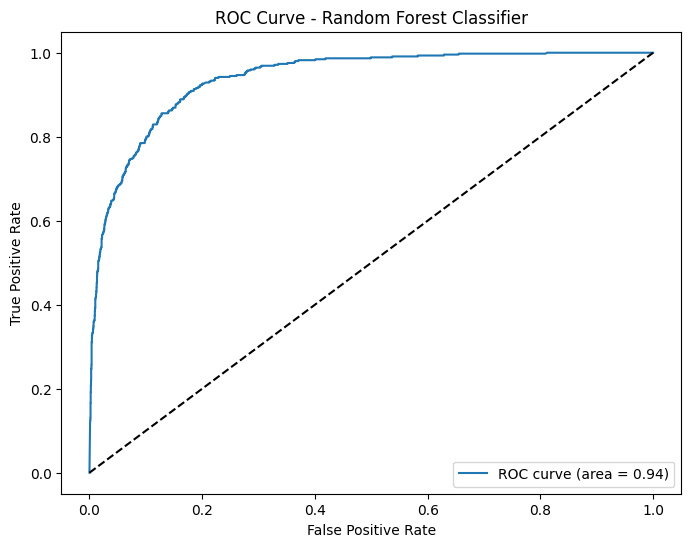

In [ ]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Create a pipeline for preprocessing and Random Forest Classifier
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train_split.select_dtypes(include=['number']).columns)
    ])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_pred_val = best_rf_model.predict(X_val_split)
y_prob_val = best_rf_model.predict_proba(X_val_split)[:, 1]

print(classification_report(y_val_split, y_pred_val))
print("ROC AUC Score:", roc_auc_score(y_val_split, y_prob_val))

# Evaluate the best model on the test set
y_pred_test = best_rf_model.predict(X_test)
y_prob_test = best_rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_test))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_test))

# Plot ROC Curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_prob_test):0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

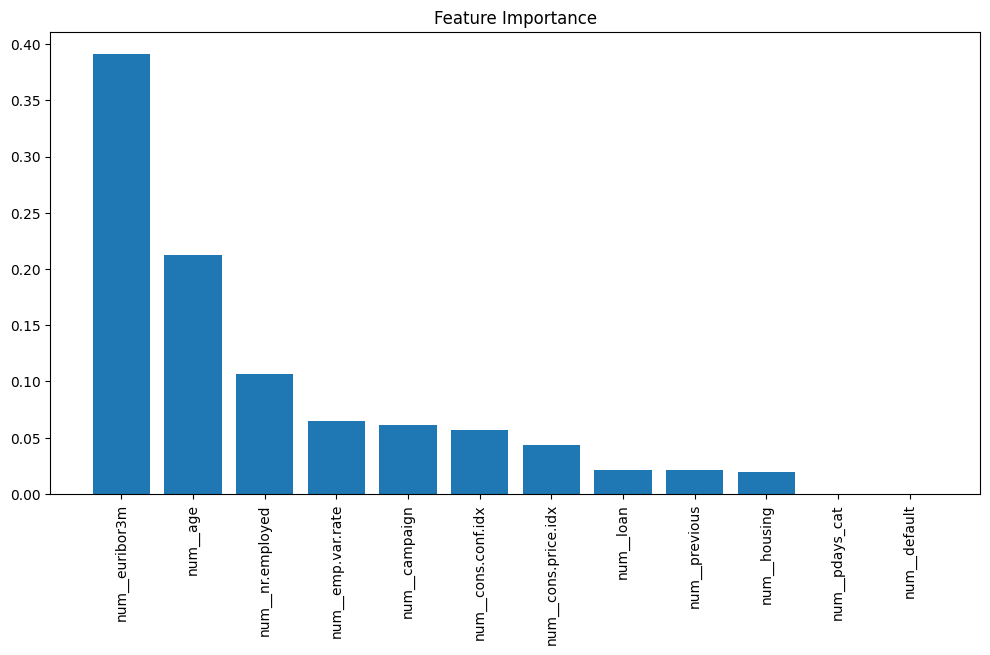

In [ ]:
import matplotlib.pyplot as plt

#'best_rf_model' is my trained RandomForestClassifier
importances = best_rf_model.named_steps['classifier'].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names from preprocessor if available
try:
    feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    # If preprocessor doesn't have get_feature_names_out,
    # using the original feature names as a fallback
    feature_names = X_train_split.columns

# Rearrange feature names to match sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(12, 6))

# Create plot title
plt.title("Feature Importance")

# Add bars, using the length of importances for the x-axis range
plt.bar(range(len(importances)), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(importances)), names, rotation=90)

# Show plot
plt.show()

In [ ]:
# Compare the two Random Forest models without ans with hyperparameter tunning

print("Random Forest without Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc}")


print("\nRandom Forest with Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_test)}")

Random Forest without Hyperparameter Tuning:
Accuracy: 0.9907744598203447
ROC AUC Score: 0.9989330628410874

Random Forest with Hyperparameter Tuning:
Accuracy: 0.9121145909201263
ROC AUC Score: 0.9393408444097329


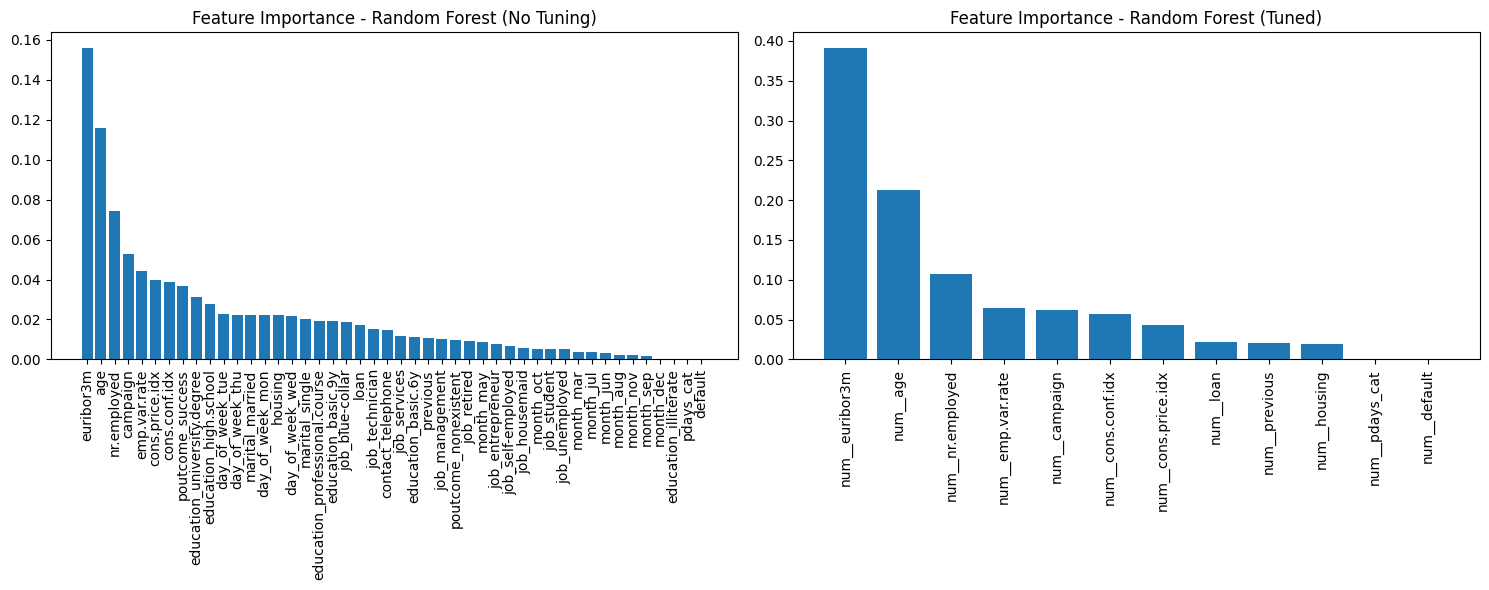

In [ ]:
# 'rf_classifier' is my first RandomForestClassifier (without tuning)
importances_no_tuning = rf_classifier.feature_importances_
indices_no_tuning = np.argsort(importances_no_tuning)[::-1]
names_no_tuning = [X_train_resampled.columns[i] for i in indices_no_tuning]

#For better comparison, creating combined plot:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("Feature Importance - Random Forest (No Tuning)")
plt.bar(range(X_train_resampled.shape[1]), importances_no_tuning[indices_no_tuning])
plt.xticks(range(X_train_resampled.shape[1]), names_no_tuning, rotation=90)

plt.subplot(1, 2, 2)
plt.title("Feature Importance - Random Forest (Tuned)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), names, rotation=90)

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

neural network without hyperparamter tunning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score


# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split.select_dtypes(include=['number']))
X_val_scaled = scaler.transform(X_val_split.select_dtypes(include=['number']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['number']))


# Define the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train_split, epochs=50, batch_size=32,
                    validation_data=(X_val_scaled, y_val_split), callbacks=[early_stopping])

# Evaluate the model
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7291 - loss: 0.5493 - val_accuracy: 0.7426 - val_loss: 0.5255
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7433 - loss: 0.5292 - val_accuracy: 0.7479 - val_loss: 0.5232
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7425 - loss: 0.5275 - val_accuracy: 0.7484 - val_loss: 0.5203
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7494 - loss: 0.5190 - val_accuracy: 0.7460 - val_loss: 0.5247
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7492 - loss: 0.5223 - val_accuracy: 0.7492 - val_loss: 0.5202
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7509 - loss: 0.5170 - val_accuracy: 0.7451 - val_loss: 0.5182
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7522 - loss: 0.5158 - val_accuracy: 0.7479 - val_loss: 0.5153
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7521 - loss: 0.5142 - val_accurac

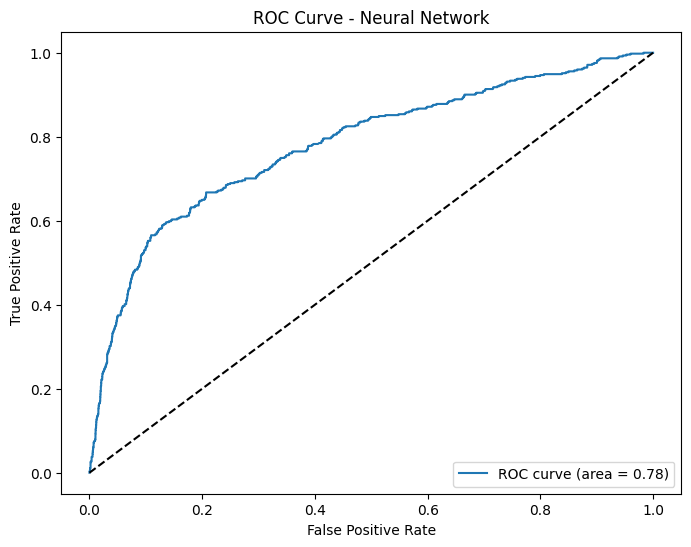

In [ ]:

# Plot ROC Curve for the test set (Neural Network)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_prob):0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

MLP classifier with hyper parameter tunned

In [ ]:

!pip install scikeras
!pip install --upgrade scikit-learn
!pip install --upgrade scikeras

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Define the parameter grid
param_grid_nn = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200]
}

#GridSearchCV
grid_search_nn = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid_nn,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)


grid_search_nn.fit(X_train, y_train)    # model fitting

# Print the best parameters and score
print("Best Parameters:", grid_search_nn.best_params_)
print("Best ROC-AUC Score:", grid_search_nn.best_score_)

# MLP classifier with the best hyperparameters figured out
mlp_optimized = MLPClassifier(activation='relu',
                              hidden_layer_sizes=(128, 64),
                              learning_rate_init=0.001,
                              max_iter=200,
                              random_state=42,
                              solver='adam')


mlp_optimized.fit(X_train, y_train)    #training the mlp classifier

# preds
y_pred_mlp = mlp_optimized.predict(X_test)
y_prob_mlp = mlp_optimized.predict_proba(X_test)[:, 1]

# Evaluation
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
roc_auc_mlp  = roc_auc_score(y_test, y_prob_mlp)
cm_mlp       = confusion_matrix(y_test, y_pred_mlp)

#results
print("Optimized MLP Classifier Accuracy:", accuracy_mlp)
print("Optimized MLP Classifier ROC-AUC:", roc_auc_mlp)
print("Confusion Matrix:\n", cm_mlp)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
Best ROC-AUC Score: 0.5688697754989995
Optimized MLP Classifier Accuracy: 0.896091284292304
Optimized MLP Classifier ROC-AUC: 0.7843680709534367
Confusion Matrix:
 [[3561  107]
 [ 321  130]]


In [ ]:
# Evaluate the optimized MLP classifier on the test set
from sklearn.metrics import classification_report

y_pred_mlp_test = mlp_optimized.predict(X_test)
y_prob_mlp_test = mlp_optimized.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_mlp_test))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_mlp_test))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3668
           1       0.55      0.29      0.38       451

    accuracy                           0.90      4119
   macro avg       0.73      0.63      0.66      4119
weighted avg       0.88      0.90      0.88      4119

ROC AUC Score: 0.7843680709534367


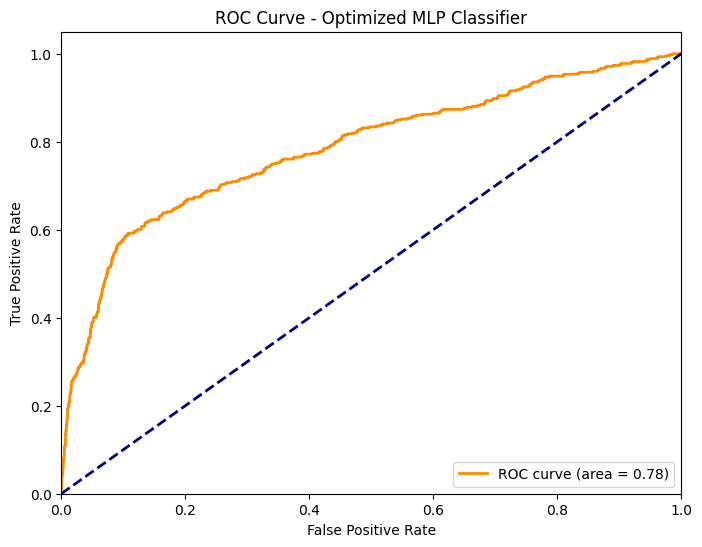

In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for the optimized MLP classifier
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_prob_mlp_test)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mlp:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized MLP Classifier')
plt.legend(loc="lower right")
plt.show()


Neural Network without Hyperparameter Tuning:
Accuracy: 0.9907744598203447
ROC AUC Score: 0.7804581845263283

Optimized MLP Classifier:
Accuracy: 0.896091284292304
ROC AUC Score: 0.7843680709534367


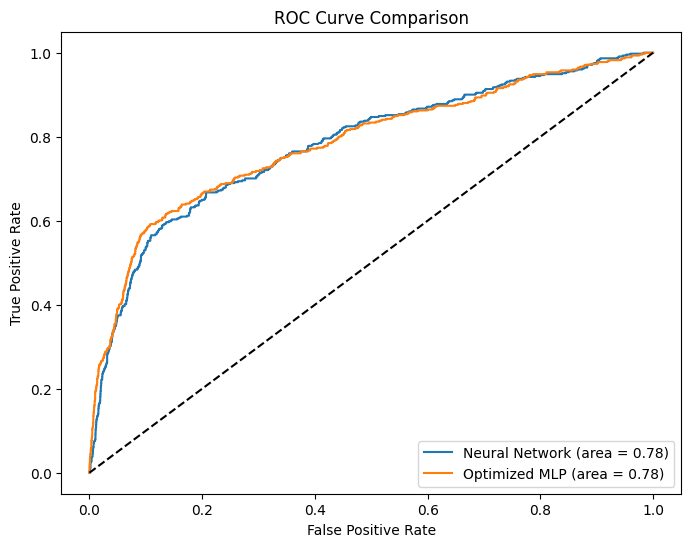

In [ ]:

# Comparison of Neural Network and MLP Classifier

print("\nNeural Network without Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")  # y_pred from neural network 1
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob)}") #  y_pred_prob from neural network 1


print("\nOptimized MLP Classifier:")
print(f"Accuracy: {accuracy_mlp_optimized}") # Accuracy from optimized MLP
print(f"ROC AUC Score: {roc_auc_mlp_optimized}") # ROC AUC from optimized MLP


# Visualize the ROC curves of both models on the same plot for direct comparison

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (area = {roc_auc_score(y_test, y_pred_prob):0.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Optimized MLP (area = {roc_auc_mlp:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


Tuned Random Forest Classifier:
Accuracy: 0.9121145909201263
ROC AUC Score: 0.9393408444097329

Optimized MLP Classifier:
Accuracy: 0.896091284292304
ROC AUC Score: 0.7843680709534367


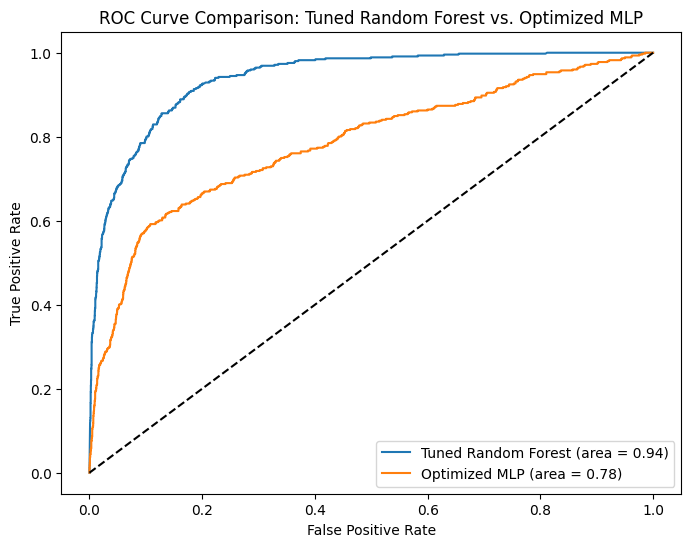

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

# Comparison of Tuned Random Forest and Optimized MLP Classifier
print("\nTuned Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_test)}")

print("\nOptimized MLP Classifier:")
print(f"Accuracy: {accuracy_mlp_optimized}")
print(f"ROC AUC Score: {roc_auc_mlp_optimized}")

# Visualize the ROC curves of both models on the same plot for direct comparison

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned Random Forest (area = {roc_auc_score(y_test, y_prob_test):0.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Optimized MLP (area = {roc_auc_mlp:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Tuned Random Forest vs. Optimized MLP')
plt.legend(loc='lower right')
plt.show()